In [23]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import pandas as pd
from os.path import abspath

import warnings
warnings.filterwarnings("ignore")

In [25]:
df = pd.read_csv(abspath('../../../data/MSFT/MSFT-5-Year.csv'), index_col=0, parse_dates=['Date'])

df.columns.name = df.index.name
df.index.name = None

df = df.filter(['Date', 'Open'])
print(df.shape)
df.head()

(1245, 1)


Date,Open
2017-03-01,64.129997
2017-03-02,64.690002
2017-03-03,63.990002
2017-03-06,63.970001
2017-03-07,64.190002


In [26]:
# Split the df into a training set and a test set
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_set, test_set = train_test_split(df, test_size=0.05, shuffle=False)

n_features = 1

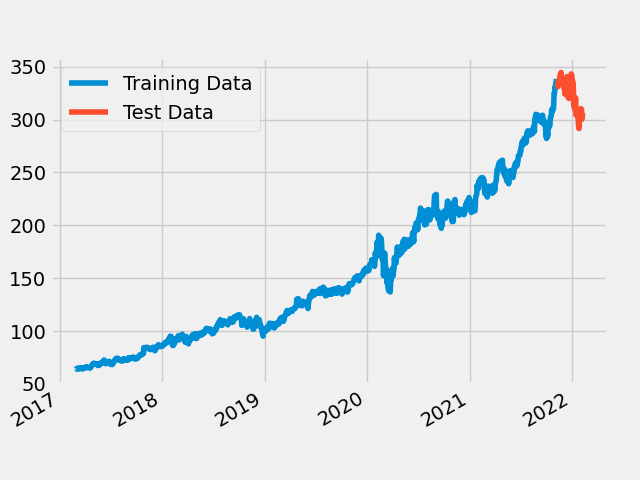

In [27]:
# Plot the training and testing data
train_set.Open.plot(label='Training Data')
test_set.Open.plot(label='Test Data')
plt.legend()

In [28]:
from sklearn.preprocessing import MinMaxScaler

transformer = MinMaxScaler()
train_scaled = transformer.fit_transform(train_set)
test_scaled = transformer.fit_transform(test_set)

In [29]:
import tensorflow as tf

#List attached GPU devices
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [30]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # type: ignore

n_input = 60

train_generator=TimeseriesGenerator(train_scaled,
                                     train_scaled,
                                      length=n_input,
                                      batch_size=32)

In [31]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

model = Sequential()
        
#Add first LSTM layer
model.add(LSTM(units=10, input_shape=(n_input, n_features)))
model.add(Dense(units=1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 10)                480       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Create an EarlyStopping callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=10)

In [33]:
from CustomAdam import CustomAdam

model.compile(optimizer=CustomAdam(), loss='mean_squared_error')
model.fit(train_generator, epochs=25, callbacks=[early_stopping])

Epoch 1/25
36/36 [==============================] - 7s 175ms/step - loss: 0.1041
Epoch 2/25
36/36 [==============================] - 6s 159ms/step - loss: 0.0389
Epoch 3/25
36/36 [==============================] - 6s 161ms/step - loss: 0.0241
Epoch 4/25
36/36 [==============================] - 6s 160ms/step - loss: 0.0165
Epoch 5/25
36/36 [==============================] - 6s 161ms/step - loss: 0.0090
Epoch 6/25
36/36 [==============================] - 6s 170ms/step - loss: 0.0032
Epoch 7/25
36/36 [==============================] - 6s 162ms/step - loss: 7.4219e-04
Epoch 8/25
36/36 [==============================] - 6s 167ms/step - loss: 2.9593e-04
Epoch 9/25
36/36 [==============================] - 6s 162ms/step - loss: 2.9390e-04
Epoch 10/25
36/36 [==============================] - 6s 163ms/step - loss: 2.7944e-04
Epoch 11/25
36/36 [==============================] - 6s 159ms/step - loss: 2.5750e-04
Epoch 12/25
36/36 [==============================] - 6s 166ms/step - loss: 2.7215e-04
E

In [34]:
model.save('/Users/aditya/Programming/stock-market-predictions/stock_market_predictions/forecasting/LSTM/MSFT-5-Year-LSTM.h5')

In [35]:
test_generator=TimeseriesGenerator(test_scaled,
                                     test_scaled,
                                      length=n_input,
                                      batch_size=32)

In [36]:
# # method to check if a file exists
# def file_exists(file_path):
#     import os
#     return os.path.isfile(file_path)

# from keras.models import load_model

# if (file_exists('/Users/aditya/Programming/stock-market-predictions/stock_market_predictions/forecasting/LSTM/MSFT-5-Year-LSTM.h5')):
#     model = load_model('/Users/aditya/Programming/stock-market-predictions/stock_market_predictions/forecasting/LSTM/MSFT-5-Year-LSTM.h5')
# else:
#     print("File does not exist")

In [37]:
inputs = df[len(df)-len(test_set)-60 : ].values
inputs = inputs.reshape(-1,1)
inputs = transformer.transform(inputs)

(1245, 1)
(123, 1)
(123, 1)
(123, 1)


In [38]:
import numpy as np

x_test = []
for i in range(60,len(inputs)):
    x_test.append(inputs[i-60:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape)

(63, 60, 1)


In [39]:
predicted = model.predict(x_test)
predicted = transformer.inverse_transform(predicted)

(63, 1)


In [41]:
print(predicted.shape)

# Convert the predicted values to a dataframe
predicted_df = pd.DataFrame(predicted)

# Rename the column to "Open"
predicted_df.columns = ['Open']

# Add a new column called "Date" that has the same index as the other dataframe
predicted_df['Date'] = df[len(df)-len(test_set)-0 : ].index

# Set the 'Date' column as the index
predicted_df = predicted_df.set_index('Date')

predicted_df.head()

(63, 1)


,Open
Date,
2021-11-08,330.752441
2021-11-09,332.871552
2021-11-10,334.463776
2021-11-11,335.293854
2021-11-12,335.237579


<AxesSubplot:xlabel='Date'>

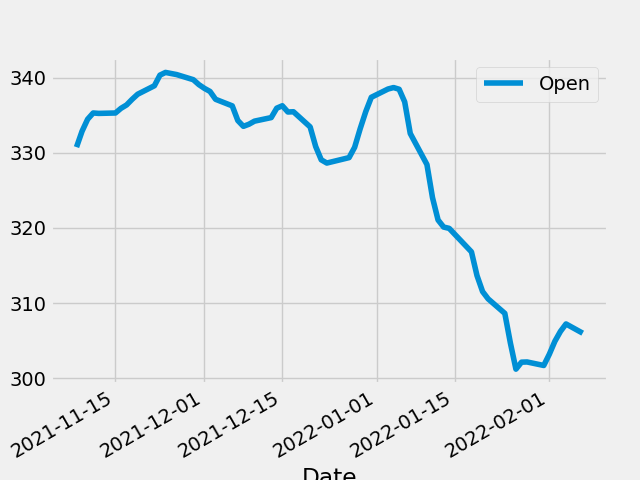

In [42]:
# Plot the predicted values
predicted_df.plot(label='Predicted')

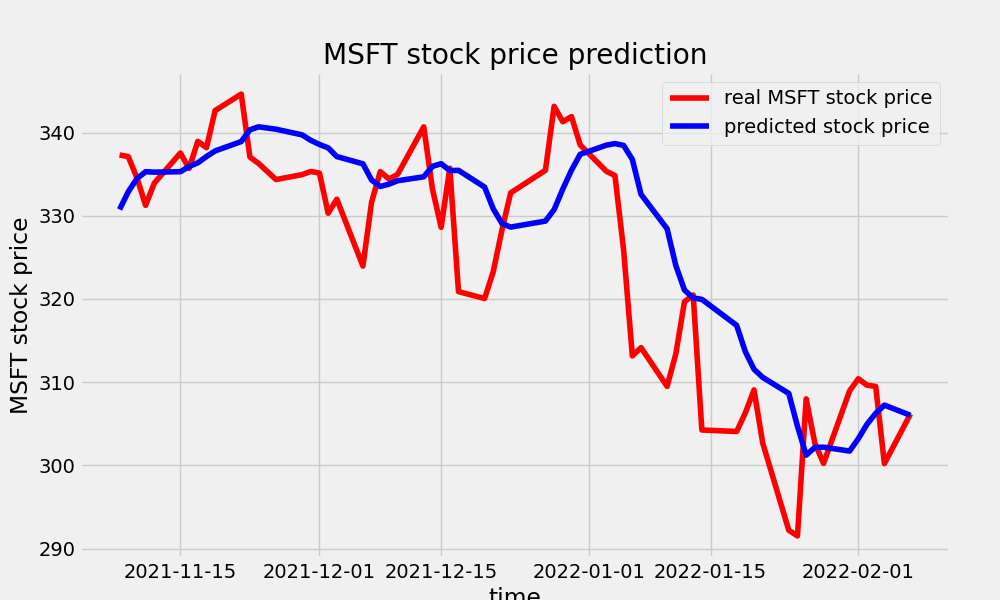

In [45]:
def plot_predictions(test, predicted):
    plt.figure(4, figsize=(10,6))
    plt.plot(test, color="red", label="real MSFT stock price")
    plt.plot(predicted, color="blue", label="predicted stock price")
    plt.title("MSFT stock price prediction")
    plt.xlabel("time")
    plt.ylabel("MSFT stock price")
    plt.legend()
    plt.show()

plot_predictions(test_set, predicted_df)

In [46]:
import math
from sklearn.metrics import mean_squared_error

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("the root mean squared error is : {}.".format(rmse))

return_rmse(test_set, predicted)

the root mean squared error is : 8.114443117308774.
